# Importing libraries required 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np

# Deifning the state space

In [4]:
# Define activations separately for indexing and instantiation
activation_names = ['sigmoid', 'tanh', 'relu', 'elu', 'selu', 'swish']
activation_map = {
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'selu': nn.SELU,
    'swish': lambda: nn.SiLU(),  # swish ≈ SiLU in PyTorch
}

def decode_action(action_id):
    if 0 <= action_id <= 41:  # Dense Layer with some number of units
        units_list = [8, 16, 32, 64, 128, 256, 512]
        units_idx = action_id // len(activation_names)
        act_idx = action_id % len(activation_names)
        units = units_list[units_idx]
        activation_name = activation_names[act_idx]
        activation_fn = activation_map[activation_name]
        return ('dense', units, activation_name)  

    elif 42 <= action_id <= 44:  # Dropout layer
        dropout_rates = [0.0, 0.2, 0.5]
        return ('dropout', dropout_rates[action_id - 42])

    elif action_id == 45:  # BatchNorm layer
        return ('batchnorm',)

    elif action_id == 46:  # Stop building layers
        return ('stop',)

    else:
        raise ValueError(f"Invalid action id: {action_id}")


# RL Environment

In [7]:
class NASMLPEnv(Env):
    def __init__(self, dataset, max_layers=10):
        self.dataset = dataset  
        self.max_layers = max_layers
        self.action_space = Discrete(47)
        self.observation_space = Box(low=0, high=1, shape=((max_layers + 10) * 3,), dtype=np.float32)  # 3 inputs per layer, layer type, number of units, and activation function
        self.architecture = []
        self.done = False

        self.best_architecture = None
        self.best_reward = -float('inf')
        self.architecture_log = []

        self.max_parameters = self._estimate_max_parameters()

    def reset(self):
        # logging the architecture for further analysis
        if self.architecture:
            self.architecture_log.append({
                'architecture': list(self.architecture),
                'reward': 0,
                'accuracy': None,
                'complexity': None,
                'complexity_epochs': None,
                'completed': False,
                'termination_reason': 'incomplete'
            })
        # resetting architecture
        self.architecture = []
        self.done = False
        return self._get_obs()

    # function for finding the max parameters of a neural network using only the dense layers (ignoring batchnorm)
    def _estimate_max_parameters(self):
        input_dim = self.dataset[0].shape[1]  
        max_units = 512
        total_params = 0
    
        for _ in range(self.max_layers):
            total_params += input_dim * max_units + max_units  
            input_dim = max_units
    
        output_dim = self.dataset[1].shape[1]
        total_params += max_units * output_dim + output_dim
    
        return total_params


    # defining action step based on the action chosen
    def step(self, action_id):
        decoded = decode_action(action_id)
        # making sure it does not choose stop as the first layer
        if len(self.architecture) == 0 and decoded[0] == 'stop':
            return self._get_obs(), -100.0, False, {}

        dense_count = sum(1 for layer in self.architecture if layer[0] == 'dense')
        
        # stopping criteria: if stop is chosen or max layers reached
        if decoded[0] == 'stop' or (decoded[0] == 'dense' and dense_count >= self.max_layers):
            self.done = True
            reward, acc, complexity, complexity_epochs = self._evaluate_model()  

            # Log architecture, reward, accuracy, and complexity
            self.architecture_log.append({
                'architecture': list(self.architecture),
                'reward': reward,
                'accuracy': acc,
                'complexity': complexity,
                'complexity_epochs': complexity_epochs,
                'completed': True,
                'termination_reason': 'stop' if decoded[0] == 'stop' else 'max_dense'
            })
        
    
            print(f"\n🎯 Final Architecture: {self.architecture}")
            print(f"🏆 Validation Accuracy (acc): {acc:.2f}%")
            print(f"⚙️  Complexity (number of parameters): {complexity}")
            print(f"🏅 Reward (acc - penalty): {reward:.2f}")
            print(f"🏅 Complexity (Number of epochs): {complexity_epochs:.2f}%\n")

            # Track best
            if reward > self.best_reward:
                self.best_reward = reward
                self.best_architecture = list(self.architecture)
                self.best_accuracy = acc  
                self.best_complexity = complexity 
                print(f"🌟 New Best Architecture Found with Reward: {reward:.2f}%")
        else:
            self.architecture.append(decoded)
            reward = 0

        return self._get_obs(), reward, self.done, {}

    # mapping the actions to numbers
    def _get_obs(self):
        obs = np.zeros(self.observation_space.shape[0])
        max_slots = self.observation_space.shape[0] // 3  # max number of layers that can be encoded
    
        for i, layer in enumerate(self.architecture[:max_slots]):  # safely clip layers
            base = i * 3
            if layer[0] == 'dense':
                obs[base] = layer[1] / 512
                obs[base + 1] = activation_names.index(layer[2]) / (len(activation_names) - 1)
                obs[base + 2] = 0
            elif layer[0] == 'dropout':
                obs[base] = layer[1]
                obs[base + 1] = -1
                obs[base + 2] = 1
            elif layer[0] == 'batchnorm':
                obs[base] = -1
                obs[base + 1] = -1
                obs[base + 2] = 2
        return obs


    # evaluating the model
    def _evaluate_model(self):
        X_train, y_train, X_val, y_val = self.dataset

        model = nn.Sequential()
        input_dim = X_train.shape[1]

        for i, layer in enumerate(self.architecture):
            if layer[0] == 'dense':
                model.add_module(f"fc{i}", nn.Linear(input_dim, layer[1]))
                model.add_module(f"act{i}", activation_map[layer[2]]())
                input_dim = layer[1]
            elif layer[0] == 'dropout':
                model.add_module(f"dropout{i}", nn.Dropout(p=layer[1]))
            elif layer[0] == 'batchnorm':
                model.add_module(f"bn{i}", nn.BatchNorm1d(input_dim))

        # defining the last layer for classification
        model.add_module("output", nn.Linear(input_dim, y_train.shape[1]))

        # compiling the model
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01) # can make the RL choose optimizer and LR also here
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

        # Applied early stopping and run on max_epochs
        best_acc = 0
        patience = 3
        patience_counter = 0
        max_epochs = 100
        epochs_used = 0
        model.train()
        for _ in range(max_epochs):  
            for xb, yb in train_loader:
                optimizer.zero_grad()
                output = model(xb)
                loss = loss_fn(output, yb)
                loss.backward()
                optimizer.step()
    
            # Early stopping check
            model.eval()
            with torch.no_grad():
                preds = model(X_val)
                acc = (preds.argmax(dim=1) == y_val.argmax(dim=1)).float().mean().item()
    
            epochs_used += 1

            # early stopping criteria
            if acc > best_acc + 1e-4:
                best_acc = acc
                patience_counter = 0
            else:
                patience_counter += 1
    
            if patience_counter >= patience:
                break

        no_of_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        max_params = self._estimate_max_parameters()
        epochs_percentage = epochs_used*100/max_epochs
        # hyperparameter to decide how much to weigh validation accuracy
        alpha = 0.8

        # calcualting reward
        reward = (alpha * acc * 100) + ((1 - alpha) * (100 - (no_of_params * epochs_used)/(max_params * max_epochs)))
        #reward = (alpha * acc * 100) + ((1 - alpha - beta) * (100 - (no_of_params*100/max_params))) + (beta * (100 - epochs_percentage))

        return reward, acc * 100, 100 - (no_of_params*100/max_params), (100 - epochs_percentage)

# Data Preprocessing

In [10]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.nn.functional import one_hot
import openml
import random
from ucimlrepo import fetch_ucirepo

# function to preprocess dataset from 1 of 3 different sources: openML, UCI, and Kaggle
def load_and_process_dataset(source, target_column=None, dataset_id=None, 
                             uci_id=None, test_size=0.1, random_state=42, n_samples=None, usecols=None):
    if source == "openml":
        if dataset_id is None:
            raise ValueError("You must provide a dataset_id for OpenML datasets.")
        dataset = openml.datasets.get_dataset(dataset_id)
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
        target_column = dataset.default_target_attribute
        df = pd.concat([X, y], axis=1)

    
    elif source == "uci":
        if uci_id is None:
            raise ValueError("You must provide uci_id when source='uci'.")

        repo     = fetch_ucirepo(id=uci_id)
        data_url = repo.metadata.data_url    
        headers  = repo.data.headers         

        if target_column is None:
            target_column = getattr(repo.metadata, "target_col", headers[-1])
        if isinstance(target_column, (list, tuple)):
            if len(target_column) == 1:
                target_column = target_column[0]
            else:
                raise ValueError(
                    f"Multiple possible targets {target_column}; please specify one."
                )

        read_kwargs = {"header": 0}
        if n_samples is not None:
            read_kwargs["nrows"] = n_samples

        # only restrict columns if user actually passed usecols
        if usecols is not None:
            if any(not isinstance(c, str) for c in usecols):
                raise TypeError("All entries in usecols must be strings")
            cols_to_read = set(usecols) | {target_column}
            read_kwargs["usecols"] = cols_to_read

        df = pd.read_csv(data_url, **read_kwargs)

    elif source == "kaggle":
        if dataset_id is None or target_column is None:
            raise ValueError("For Kaggle datasets, provide file_path and target_column.")
        df = pd.read_csv(dataset_id)  # here, dataset_id acts as the file path

    else:
        raise ValueError("source must be one of: 'openml', 'uci', 'kaggle'")

    df.dropna(inplace=True)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    X = X.apply(lambda col: col.astype(str) if col.dtype == 'object' else col)
    
    X = pd.get_dummies(X)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_tensor = one_hot(torch.tensor(y_encoded)).float()

    X_train_np, X_val_np, y_train_tensor, y_val_tensor = train_test_split(
        X_scaled, y_tensor, test_size=test_size, random_state=random_state
    )

    X_train_tensor = torch.tensor(X_train_np).float()
    X_val_tensor = torch.tensor(X_val_np).float()

    return (X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

In [12]:
# import whatever dataset you want to train the model on
dataset = load_and_process_dataset(source="uci", uci_id=31, n_samples = 100000)

In [13]:
dataset[0]

tensor([[ 0.5185,  1.0391, -0.4313,  ..., -0.0900, -0.0933, -0.0861],
        [ 0.6438, -1.0133, -0.1235,  ..., -0.0900, -0.0933, -0.0861],
        [-0.2206,  0.0081,  2.1848,  ..., -0.0900, -0.0933, -0.0861],
        ...,
        [-0.6787,  0.2297, -1.3546,  ..., -0.0900, -0.0933, -0.0861],
        [ 0.1554,  1.1162, -0.7391,  ..., -0.0900, -0.0933, -0.0861],
        [-0.3891,  0.1141,  1.8770,  ..., -0.0900, -0.0933, -0.0861]])

In [14]:
# creating NAS environment
env = NASMLPEnv(dataset=dataset, max_layers=10)

In [15]:
from stable_baselines3 import DQN

import time

start_time = time.time()

# defining DQN model with epsilon greedy and gamma hyperparameters
model = DQN(
    "MlpPolicy",
    env,
    gamma=0.99,                       
    exploration_initial_eps=1.0,     
    exploration_final_eps=0.05,      
    exploration_fraction=0.05,        
    verbose=1,
    tensorboard_log="./nas_logs/"
)

# running model for 10000 timesteps
model.learn(total_timesteps=10000)

end_time = time.time()
elapsed_time = end_time - start_time

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Logging to ./nas_logs/DQN_44

🎯 Final Architecture: [('dense', 16, 'elu'), ('batchnorm',), ('dense', 256, 'relu'), ('dense', 512, 'tanh'), ('dense', 64, 'elu'), ('dense', 128, 'tanh'), ('dense', 128, 'swish'), ('dense', 16, 'elu'), ('batchnorm',), ('dense', 32, 'sigmoid'), ('dense', 32, 'selu'), ('dense', 64, 'sigmoid'), ('dropout', 0.0)]
🏆 Validation Accuracy (acc): 66.86%
⚙️  Complexity (number of parameters): 91.61920226409896
🏅 Reward (acc - penalty): 73.49
🏅 Complexity (Number of epochs): 96.00%

🌟 New Best Architecture Found with Reward: 73.49%

🎯 Final Architecture: [('dropout', 0.5), ('dense', 256, 'elu'), ('dense', 128, 'tanh'), ('dense', 512, 'elu'), ('dense', 32, 'swish'), ('dense', 64, 'elu'), ('dense', 64, 'elu'), ('dense', 32, 'tanh'), ('dense', 128, 'tanh'), ('dense', 512, 'sigmoid'), ('dense', 256, 'relu')]
🏆 Validation Accuracy (acc): 66.86%
⚙️  Complexity (number of parameters): 85.75792424201315
🏅 Reward (acc - penalty): 73.49
🏅 Complexity (Number of epochs): 96.00%


In [16]:
# saving model
model.save("nas_agent_checkpoint_alpha_0.8_epoch_reward_uci31_no_stop_1st")

In [17]:
# analyze the results

In [18]:
print(elapsed_time)

103108.78740620613


In [19]:
print(env.best_architecture)

[('dense', 256, 'sigmoid')]


In [20]:
print(f"\n Best Reward: {env.best_reward:.2f}%")


 Best Reward: 93.62%


In [21]:
print(f"\n Best Accuracy: {env.best_accuracy:.2f}%")


 Best Accuracy: 92.03%


In [ ]:
print(f"\n Best Complexity: {env.best_complexity:.2f}%")


 Best Complexity: 99.34%


In [ ]:
print(f"\n Best Complexity Epochs: {env.complexity_epochs:.2f}%")

AttributeError: 'NASMLPEnv' object has no attribute 'complexity_epochs'

In [24]:
# again sigmoid?

In [50]:
# test normal architecture for this and compare the accuracy, build this also to see number of epochs

# Obtaining data from the NAS logs

In [26]:
import pandas as pd

flat_data = []

for arch_id, run in enumerate(env.architecture_log):
    reward = run['reward']
    accuracy = run.get('accuracy', None)
    complexity = run.get('complexity', None)
    complexity_epochs = run.get('complexity_epochs', None)
    completed = run.get('completed', False)
    termination_reason = run.get('termination_reason', 'unknown')

    for i, layer in enumerate(run['architecture']):
        layer_type = layer[0]
        layer_info = {
            'arch_id': arch_id,
            'layer_num': i + 1,
            'layer_type': layer_type,
            'units': None,
            'activation': None,
            'dropout_rate': None,
            'reward': reward,
            'accuracy': accuracy,
            'complexity': complexity,
            'complexity_epochs': complexity_epochs,
            'completed': completed,
            'termination_reason': termination_reason
        }

        if layer_type == 'dense':
            layer_info['units'] = layer[1]
            layer_info['activation'] = layer[2]

        elif layer_type == 'dropout':
            layer_info['dropout_rate'] = layer[1]

        flat_data.append(layer_info)

# Create DataFrame and export to CSV
df = pd.DataFrame(flat_data)
df.to_csv("architecture_analysis_updated_alpha_0.8_final_reward_formula_forest.csv", index=False)

In [28]:
#df = pd.read_csv("architecture_analysis_updated_alpha_0.9.csv")

In [30]:
df

,arch_id,layer_num,layer_type,units,activation,dropout_rate,reward,accuracy,complexity,complexity_epochs,completed,termination_reason
0,0,1,dense,16.0,elu,NaN,73.487331,66.860002,91.619202,96.0,True,max_dense
1,0,2,batchnorm,NaN,None,NaN,73.487331,66.860002,91.619202,96.0,True,max_dense
2,0,3,dense,256.0,relu,NaN,73.487331,66.860002,91.619202,96.0,True,max_dense
3,0,4,dense,512.0,tanh,NaN,73.487331,66.860002,91.619202,96.0,True,max_dense
4,0,5,dense,64.0,elu,NaN,73.487331,66.860002,91.619202,96.0,True,max_dense
...,...,...,...,...,...,...,...,...,...,...,...,...
11123,4967,1,dense,8.0,elu,NaN,0.000000,NaN,NaN,NaN,False,incomplete
11124,4968,1,dense,16.0,selu,NaN,88.615981,85.769999,99.958300,78.0,True,stop
11125,4969,1,dense,16.0,selu,NaN,0.000000,NaN,NaN,NaN,False,incomplete
11126,4970,1,dense,8.0,elu,NaN,86.743993,83.429998,99.979004,88.0,True,stop


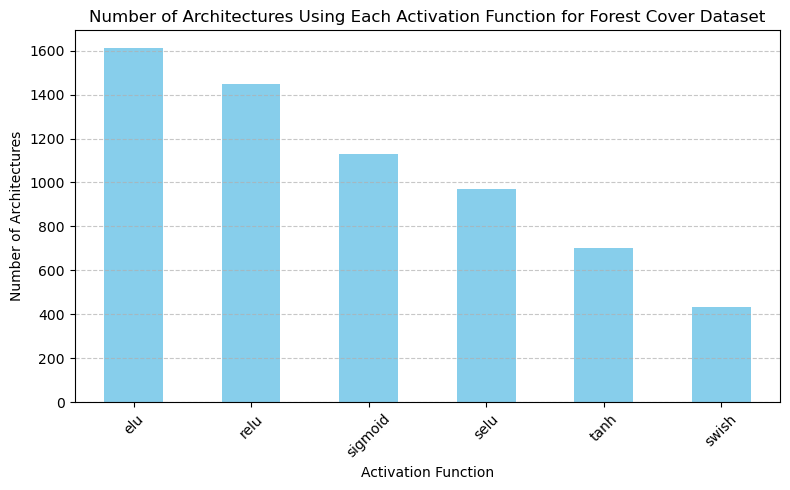

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and contains a column "activation" and "arch_id"

# Drop rows where activation is NaN (e.g., for batchnorm or dropout layers)
df_activations = df.dropna(subset=['activation'])

# Count how many architectures used each activation function at least once
arch_activation_counts = (
    df_activations
    .groupby('activation')['arch_id']
    .nunique()
    .sort_values(ascending=False)
)

# Plot the result
plt.figure(figsize=(8, 5))
arch_activation_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Architectures Using Each Activation Function for Forest Cover Dataset')
plt.xlabel('Activation Function')
plt.ylabel('Number of Architectures')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


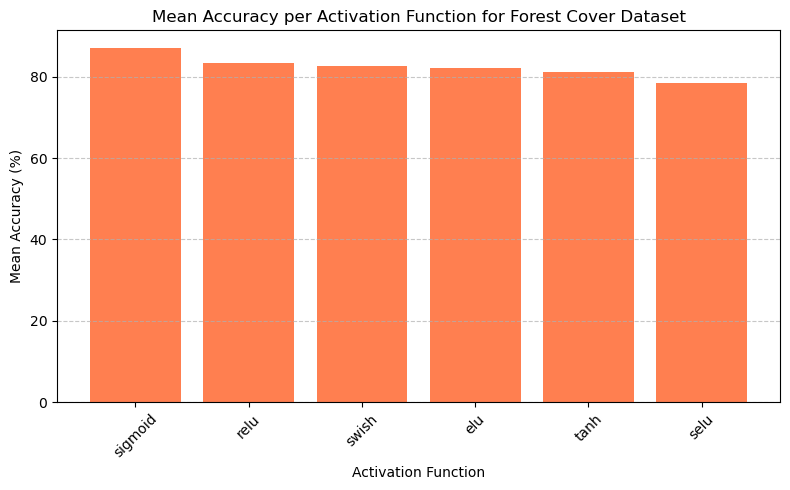

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Drop NaNs in activation or accuracy (optional for robustness)
df_clean = df.dropna(subset=['activation', 'accuracy'])

# Step 2: Get architecture-level activation-accuracy mapping
arch_acc = df_clean.groupby('arch_id').first()[['accuracy']]  # one accuracy per arch_id
arch_acts = df_clean.groupby('arch_id')['activation'].unique()  # all activations used in that arch

# Step 3: Build mapping: activation → list of accuracies
from collections import defaultdict

act_to_accs = defaultdict(list)

for arch_id, activations in arch_acts.items():
    acc = arch_acc.loc[arch_id, 'accuracy']
    for act in activations:
        act_to_accs[act].append(acc)

# Step 4: Compute mean accuracy for each activation
act_mean_acc = {act: sum(accs)/len(accs) for act, accs in act_to_accs.items()}
act_mean_acc = dict(sorted(act_mean_acc.items(), key=lambda x: x[1], reverse=True))

# Step 5: Plot the result
plt.figure(figsize=(8, 5))
plt.bar(act_mean_acc.keys(), act_mean_acc.values(), color='coral')
plt.title('Mean Accuracy per Activation Function for Forest Cover Dataset')
plt.xlabel('Activation Function')
plt.ylabel('Mean Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


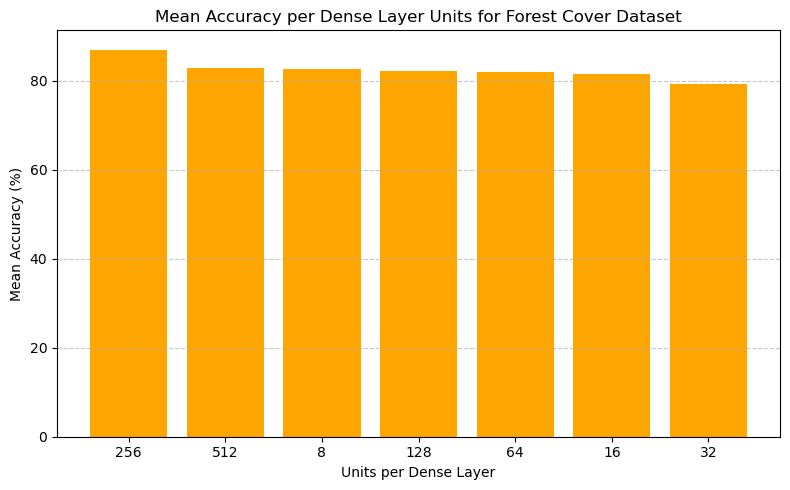

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Drop NaNs in 'units' and 'accuracy'
df_units = df.dropna(subset=['units', 'accuracy'])

# Step 2: Unique units used per architecture and corresponding accuracy
arch_units = df_units.groupby('arch_id')['units'].unique()
arch_acc   = df_units.groupby('arch_id').first()['accuracy']

# Step 3: units → list of accuracies
unit_to_accs = defaultdict(list)
for arch_id, units_used in arch_units.items():
    acc = arch_acc.loc[arch_id]
    for unit_val in units_used:
        unit_to_accs[int(unit_val)].append(acc)

# Step 4: mean accuracy per unit, sorted by accuracy descending
unit_mean_acc = {u: sum(accs) / len(accs) for u, accs in unit_to_accs.items()}
unit_mean_acc = dict(sorted(unit_mean_acc.items(), key=lambda x: x[1], reverse=True))

# Step 5: Bar plot
plt.figure(figsize=(8, 5))
plt.bar([str(u) for u in unit_mean_acc.keys()], unit_mean_acc.values(), color='orange')
plt.title('Mean Accuracy per Dense Layer Units for Forest Cover Dataset')
plt.xlabel('Units per Dense Layer')
plt.ylabel('Mean Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
df[df['accuracy'].isna()].head(30)

,arch_id,layer_num,layer_type,units,activation,dropout_rate,reward,accuracy,complexity,complexity_epochs,completed,termination_reason
13,1,1,dense,16.0,elu,NaN,0.0,NaN,NaN,NaN,False,incomplete
14,1,2,batchnorm,NaN,None,NaN,0.0,NaN,NaN,NaN,False,incomplete
15,1,3,dense,256.0,relu,NaN,0.0,NaN,NaN,NaN,False,incomplete
16,1,4,dense,512.0,tanh,NaN,0.0,NaN,NaN,NaN,False,incomplete
17,1,5,dense,64.0,elu,NaN,0.0,NaN,NaN,NaN,False,incomplete
18,1,6,dense,128.0,tanh,NaN,0.0,NaN,NaN,NaN,False,incomplete
19,1,7,dense,128.0,swish,NaN,0.0,NaN,NaN,NaN,False,incomplete
20,1,8,dense,16.0,elu,NaN,0.0,NaN,NaN,NaN,False,incomplete
21,1,9,batchnorm,NaN,None,NaN,0.0,NaN,NaN,NaN,False,incomplete
22,1,10,dense,32.0,sigmoid,NaN,0.0,NaN,NaN,NaN,False,incomplete


In [34]:
df.sort_values('accuracy', ascending = False).head(60)

,arch_id,layer_num,layer_type,units,activation,dropout_rate,reward,accuracy,complexity,complexity_epochs,completed,termination_reason
6754,1920,1,dense,256.0,sigmoid,NaN,93.623510,92.030001,99.337175,63.0,True,stop
6306,1502,1,dense,256.0,sigmoid,NaN,93.391642,91.740000,99.337175,73.0,True,stop
7162,2286,1,dense,256.0,sigmoid,NaN,93.383575,91.729999,99.337175,68.0,True,stop
6308,1504,1,dense,256.0,sigmoid,NaN,93.311617,91.640002,99.337175,71.0,True,stop
6560,1744,1,dense,256.0,sigmoid,NaN,93.311551,91.640002,99.337175,66.0,True,stop
6614,1794,1,dense,256.0,sigmoid,NaN,93.303642,91.630000,99.337175,73.0,True,stop
6396,1588,1,dense,256.0,sigmoid,NaN,93.295521,91.619998,99.337175,64.0,True,stop
6440,1630,1,dense,256.0,sigmoid,NaN,93.287604,91.610003,99.337175,70.0,True,stop
6886,2020,1,dense,256.0,sigmoid,NaN,93.279656,91.600001,99.337175,74.0,True,stop
6288,1484,1,dense,256.0,sigmoid,NaN,93.239720,91.549999,99.337175,79.0,True,stop


In [36]:
df[df['accuracy'] < 60].head(100)

,arch_id,layer_num,layer_type,units,activation,dropout_rate,reward,accuracy,complexity,complexity_epochs,completed,termination_reason
2760,278,1,dense,64.0,elu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2761,278,2,dense,64.0,elu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2762,278,3,dense,64.0,elu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2763,278,4,dense,64.0,elu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2764,278,5,dense,64.0,elu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2765,278,6,dense,64.0,elu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2766,278,7,dense,32.0,selu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2767,278,8,dense,32.0,selu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2768,278,9,dense,32.0,selu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense
2769,278,10,dense,32.0,selu,NaN,37.487727,21.86,98.756123,89.0,True,max_dense


In [38]:
df[df['layer_type'] == 'batchnorm']['accuracy'].mean()

73.99416814247768

In [40]:
df[df['layer_type'] == 'dropout']['accuracy'].mean()

74.09736377986397

In [42]:
df.groupby('arch_id')['accuracy'].mean()

arch_id
0       66.860002
1             NaN
2       66.860002
3             NaN
4       66.860002
          ...    
4967          NaN
4968    85.769999
4969          NaN
4970    83.429998
4971          NaN
Name: accuracy, Length: 4972, dtype: float64

In [44]:
df[df['activation'] == 'relu']

,arch_id,layer_num,layer_type,units,activation,dropout_rate,reward,accuracy,complexity,complexity_epochs,completed,termination_reason
2,0,3,dense,256.0,relu,NaN,73.487331,66.860002,91.619202,96.0,True,max_dense
15,1,3,dense,256.0,relu,NaN,0.000000,NaN,NaN,NaN,False,incomplete
36,2,11,dense,256.0,relu,NaN,73.486862,66.860002,85.757924,96.0,True,max_dense
47,3,11,dense,256.0,relu,NaN,0.000000,NaN,NaN,NaN,False,incomplete
48,4,1,dense,64.0,relu,NaN,73.487780,66.860002,97.223014,96.0,True,max_dense
...,...,...,...,...,...,...,...,...,...,...,...,...
11051,4909,1,dense,128.0,relu,NaN,0.000000,NaN,NaN,NaN,False,incomplete
11052,4910,1,dense,128.0,relu,NaN,89.927916,87.410003,99.668441,87.0,True,stop
11053,4911,1,dense,128.0,relu,NaN,0.000000,NaN,NaN,NaN,False,incomplete
11099,4956,2,dense,128.0,relu,NaN,89.447886,86.809999,99.565255,87.0,True,stop


In [46]:
df.groupby('activation')['accuracy'].mean()

activation
elu        78.930027
relu       81.333827
selu       75.470875
sigmoid    85.561412
swish      81.711503
tanh       77.441716
Name: accuracy, dtype: float64

In [48]:
df.groupby('units')['accuracy'].mean()

units
8.0      82.378045
16.0     80.976057
32.0     75.745692
64.0     78.005686
128.0    77.980356
256.0    86.104923
512.0    79.196412
Name: accuracy, dtype: float64

In [ ]:
# analyze effect of different units in each layer
# analyze effect of different activation functions
# analyze the effect of different layers